One of the first metrics that our group thought of was safety, no matter what the benefits of a neighborhood are, if there is a high crime rate. In order to get measurable metric, I needed to import the Pittsburgh arrests CSV file and count the number of times a crime was committed in certian neighborhood in order to calculate crime rates for each neighborhood.

The first step is displayed below:


<AxesSubplot:>

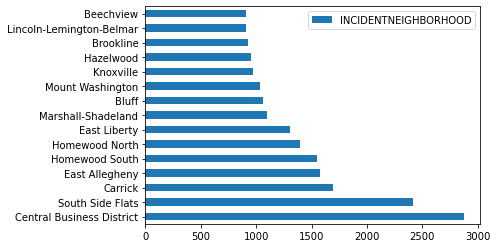

In [1]:
import pandas as pd
import geopandas
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
#the matplotlib inline allows you to display all graphs in Jupyter Notebooks
#the matplotlib.pyplot import allows you to manipulate plot, can use interface to generate plot

#create the initial read in file
arrestFile = pd.read_csv("CSVs/Arrests.csv")

#create a new DataFrame that counts the number of occurances of arrests by neighborhood
arrestsPerHood = pd.DataFrame(arrestFile["INCIDENTNEIGHBORHOOD"].value_counts(ascending = False))

#displays the data
arrestsPerHood.head(15).plot.barh()

After counting my data, I needed to import data from a separate CSV on population data for the neighborhoods in Pittsburgh. I then need to merge the population data in this new DataFrame with the numArrests DataFrame and divide the number of arrests by the population and multiply by 1,000 to find the crime rate per 1,000 people.

In the population data, I encountered some varying ways of dsiplaying neighborhood names such as Mount Oliver and the Mount Oliver Borough. I first went through the data and changed the names to match eachother so that the DataFrames would contain both the proper arrests and population data. I did run into the name "Mt. Oliver Neighborhood", which was not as explicit about which neighborhood it was. I decided to categorize this into Mount Oliver as the "neighborhood" section of the name delineated this category from the borough.

The next steps are displayed in the following cell:

In [2]:
#reads in csv containing populations for neighborhoods
hoodInfo = pd.read_csv("CSVs/total-population.csv")

# the index/key of the number of occurances is the population name, but I want this as a column
#therefore, i reset the index of the dataframe so that the nieghborhoods is its own column
resetIndex = arrestsPerHood.reset_index()

# I rename the columns to properly describe the data
numArrests = resetIndex.rename(columns = {"INCIDENTNEIGHBORHOOD" : "numOfArrests", 
                                          "index" : "Neighborhood"})

# merge the number of arrests with the populations so that ___________
arrestAndPop = numArrests.merge(hoodInfo, how = "right", on = "Neighborhood").drop(columns = ["Id", "Margin of Error; Total"])

# rename the population column
arrestAndPop = arrestAndPop.rename(columns = {"Estimate; Total" : "Population"})

# display revised data
arrestAndPop.head()

,Neighborhood,numOfArrests,Population
0,Allegheny Center,864,1411.0
1,Allegheny West,92,343.0
2,Allentown,690,2558.0
3,Arlington,209,1852.0
4,Arlington Heights,111,272.0


Now that I had combined all of the data into one DataFrame, I needed to find the crime rate for each neighborhood so that the data is standardized. I did this by dividing the number of arrests by the population and multiplying the data by 1,000.

The steps are below:

In [3]:
arrestAndPop["Crime_Ratio"] = arrestAndPop["numOfArrests"] / arrestAndPop["Population"]

arrestAndPop["Crime_Ratio"] = arrestAndPop["Crime_Ratio"] * 1000

arrestAndPop.sample(15) 

,Neighborhood,numOfArrests,Population,Crime_Ratio
29,Elliott,460,2491.0,184.664793
35,Glen Hazel,105,716.0,146.648045
47,Lower Lawrenceville,192,2572.0,74.650078
22,Crafton Heights,393,3964.0,99.142281
68,Shadyside,713,13562.0,52.573367
70,South Oakland,245,2921.0,83.875385
13,Brookline,928,13160.0,70.516717
80,Strip District,352,747.0,471.218206
15,Carrick,1693,10122.0,167.259435
75,Spring Hill-City View,541,2456.0,220.276873


# Plotting

<AxesSubplot:>

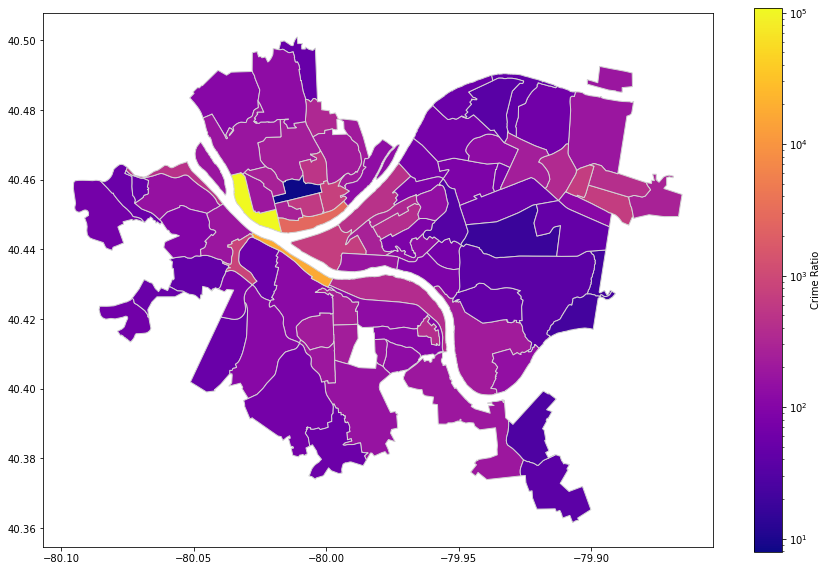

In [66]:
# crs for longitude and latitude
crs = "EPSG:4326"

# read in shape file for neighborhoods
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

# convert coordinate system to longitude and latitude
neighborhoods = neighborhoods.to_crs(crs)

# merge the neighborhoods file for the map with crime rate data
crime_map = neighborhoods.merge(arrestAndPop, how = "left", left_on = "hood", 
                                right_on = "Neighborhood") 
#shape file MISSING MOUNT OLIVER BOROUGH

# display map with my parameters
crime_map.plot(column="Crime_Ratio",
               cmap = "plasma",
               edgecolor = "lightgrey", 
               legend = True,
               legend_kwds = {"label" : "Crime Ratio"}, 
               figsize = (15, 10),
               norm = matplotlib.colors.LogNorm(vmin = crime_map['Crime_Ratio'].min(), vmax = crime_map['Crime_Ratio'].max())
              )

When plotting the data, neighborhoods such as Chateau, North Shore, and South Shore had crime rates that were so large, it made the data difficult to display. Therefore I put the data along a log based scale. After seeing how the crime ratios looked on the map, I decided to remove the three neighborhoods with the highest crime rates in order to see a better comparison among the other neighborhoods.

<AxesSubplot:>

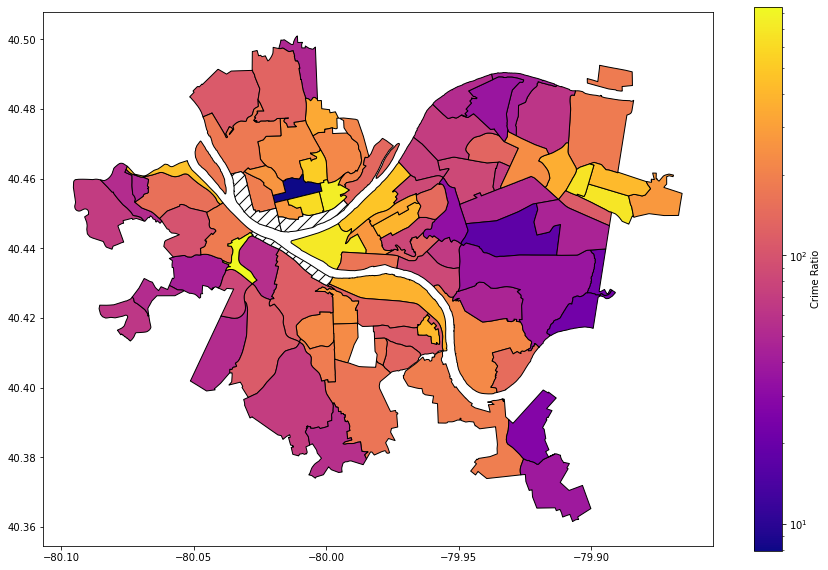

In [69]:
# create query masks for highest neighborhoods
query_mask1 = arrestAndPop["Neighborhood"] != "Chateau"
query_mask2 = arrestAndPop["Neighborhood"] != "South Shore"
query_mask3 = arrestAndPop["Neighborhood"] != "North Shore"

# filter the data. Have to use bitwise operators
lower_values = arrestAndPop[query_mask1 & query_mask2 & query_mask3]

# merge the removed data with the neighborhoods dataframe
lower_crime_map = neighborhoods.merge(lower_values, how = "left", left_on = "hood", right_on = "Neighborhood")

# plot the new data but signify what I removed
lower_crime_map.plot(column = "Crime_Ratio", 
                     cmap = "plasma",
                     edgecolor = "black",
                     legend = True,
                     legend_kwds = {"label" : "Crime Ratio"},
                     missing_kwds = {
                         "color" : "white",
                         "edgecolor" : "black",
                         "hatch" : "//"
                                    },
                     figsize = (15, 10),
                     norm = matplotlib.colors.LogNorm()
                    )